# Dimensionality Reduction with PCA - AAPL Features

This notebook applies PCA to reduce dimensionality of engineered microstructure features from AAPL trade and aggregate data.

**Objective:**

- Load combined features from notebooks 10, 15, and 20
- Apply PCA to ~75 microstructure features
- Analyze variance explained and principal component interpretation
- Test PCA stability across time windows
- Save transformed features for downstream modeling

**Data sources:**

- Basic + Advanced features: `AAPL_features_combined.parquet` (from notebook 15)
- Hawkes features: `AAPL_hawkes_features.parquet` (from notebook 20)

**Note:** We're working with Phase 1 data (trades + aggregates only, no LOB depth)


## 1. Setup and Imports


In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
# Visualization settings
plt.style.use("seaborn-v0_8-paper")
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.weight": "bold",
        "axes.labelweight": "bold",
        "axes.titleweight": "bold",
        "axes.linewidth": 1.2,
        "axes.spines.top": False,
        "axes.spines.right": False,
    }
)
%matplotlib inline

from src.config import (
    RAW_DATA_DIR,
    INTERIM_DATA_DIR, 
    PROCESSED_DATA_DIR,
    FIGURES_DIR,
    MODELS_DIR
)

# Create output directories
(FIGURES_DIR / 'pca').mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Set random seed for reproducibility
np.random.seed(42)

print("✓ Setup complete")
print(f"  Data directory: {PROCESSED_DATA_DIR}")
print(f"  Figures directory: {FIGURES_DIR / 'pca'}")
print(f"  Models directory: {MODELS_DIR}")

✓ Setup complete
  Data directory: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../data/processed
  Figures directory: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/pca
  Models directory: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../models


## 2. Load Features

Load the combined features from previous notebooks.


In [2]:
# Load combined features from notebook 15 (includes basic + advanced features)
print("Loading combined features...")
combined_features = pd.read_parquet(
    PROCESSED_DATA_DIR / "AAPL_features_combined.parquet"
).reset_index()  # Reset index to make timestamp a column

print(f"\n✓ Combined features shape: {combined_features.shape}")
print(f"  Columns: {len(combined_features.columns)}")
print(
    f"  Date range: {combined_features['timestamp'].min()} to {combined_features['timestamp'].max()}"
)
print(f"\nFirst few columns: {list(combined_features.columns[:10])}")

Loading combined features...

✓ Combined features shape: (575, 76)
  Columns: 76
  Date range: 2024-12-09 14:00:00+00:00 to 2024-12-10 00:59:00+00:00

First few columns: ['timestamp', 'agg_volume', 'agg_vwap', 'agg_open', 'agg_close', 'agg_high', 'agg_low', 'agg_trades', 'agg_estimated_spread', 'agg_mid_price']


In [3]:
# Load Hawkes features from notebook 20
print("Loading Hawkes features...")
hawkes_features = pd.read_parquet(
    PROCESSED_DATA_DIR / "AAPL_hawkes_features.parquet"
).reset_index()  # Reset index to make timestamp a column

print(f"\n✓ Hawkes features shape: {hawkes_features.shape}")
print(f"  Columns: {list(hawkes_features.columns)}")
print(
    f"\nHawkes features are rolling window estimates (200 trades/window, 20 trade stride)"
)

Loading Hawkes features...

✓ Hawkes features shape: (213, 12)
  Columns: ['index', 'timestamp', 'mu', 'alpha', 'beta', 'branching_ratio', 'window_start', 'window_end', 'n_events', 'regime', 'regime_binary', 'regime_duration']

Hawkes features are rolling window estimates (200 trades/window, 20 trade stride)


## 3. Merge Features with Time-Based Alignment

The Hawkes features are rolling window estimates. We'll merge them with the 1-minute aggregate features using time-based join.


In [4]:
# Convert Hawkes timestamps if they're in seconds
print("Merging features...")
print(f"\nCombined features timestamp type: {combined_features['timestamp'].dtype}")
print(f"Hawkes features timestamp type: {hawkes_features['timestamp'].dtype}")

# Check if Hawkes timestamps need conversion
if hawkes_features["timestamp"].dtype in ["float64", "int64"]:
    print("\nConverting Hawkes timestamps from seconds to datetime...")
    reference_time = combined_features["timestamp"].min()
    hawkes_features["timestamp"] = reference_time + pd.to_timedelta(
        hawkes_features["timestamp"], unit="s"
    )
    print(f"  Reference time: {reference_time}")
    print(
        f"  Hawkes timestamp range: {hawkes_features['timestamp'].min()} to {hawkes_features['timestamp'].max()}"
    )

# Sort both dataframes
combined_sorted = combined_features.sort_values("timestamp").reset_index(drop=True)
hawkes_sorted = hawkes_features.sort_values("timestamp").reset_index(drop=True)

print(f"\nSorted dataframes:")
print(f"  Combined features: {len(combined_sorted):,} rows")
print(f"  Hawkes features: {len(hawkes_sorted):,} rows")

Merging features...

Combined features timestamp type: datetime64[ns, UTC]
Hawkes features timestamp type: float64

Converting Hawkes timestamps from seconds to datetime...
  Reference time: 2024-12-09 14:00:00+00:00
  Hawkes timestamp range: 2024-12-09 14:39:52.293432938+00:00 to 2024-12-10 00:12:10.602190251+00:00

Sorted dataframes:
  Combined features: 575 rows
  Hawkes features: 213 rows


In [5]:
# Merge using merge_asof (time-based join)
features_merged = pd.merge_asof(
    combined_sorted,
    hawkes_sorted,
    on="timestamp",
    direction="backward",  # Use most recent Hawkes estimate
    tolerance=pd.Timedelta("5min"),  # Reject matches older than 5 minutes
)

print(f"\n✓ Merged features shape: {features_merged.shape}")
print(f"  Total columns: {len(features_merged.columns)}")

# Check for missing values
missing_counts = features_merged.isnull().sum()
if missing_counts.sum() > 0:
    print(f"\nMissing values detected: {missing_counts.sum()}")
    print("\nColumns with missing values:")
    print(missing_counts[missing_counts > 0].head(10))

    # Identify Hawkes columns
    hawkes_cols = [col for col in hawkes_features.columns if col != "timestamp"]
    hawkes_missing = features_merged[hawkes_cols].isnull().sum()

    if hawkes_missing.sum() > 0:
        print(
            f"\nHawkes features missing: {hawkes_missing.sum()} (early timestamps before first Hawkes estimate)"
        )
        print("Applying backward fill...")
        features_merged[hawkes_cols] = features_merged[hawkes_cols].fillna(
            method="bfill"
        )

        # Check again
        remaining = features_merged[hawkes_cols].isnull().sum().sum()
        if remaining > 0:
            print(f"Still missing after bfill: {remaining}, applying forward fill...")
            features_merged[hawkes_cols] = features_merged[hawkes_cols].fillna(
                method="ffill"
            )

    # Handle any other missing values
    other_missing = features_merged.isnull().sum().sum()
    if other_missing > 0:
        print(f"\nOther missing values: {other_missing}")
        print("Filling with forward fill...")
        features_merged = features_merged.fillna(method="ffill").fillna(method="bfill")

    print(f"\n✓ Final missing values: {features_merged.isnull().sum().sum()}")
else:
    print("\n✓ No missing values - perfect alignment!")

# Show sample - dynamically select available columns
print("\nSample of merged data (first 5 rows):")
# Always show timestamp first, then pick some available columns
display_cols = ["timestamp"]

# Add some common feature columns if they exist
candidate_cols = [
    "close",
    "mid_price",
    "vwap",
    "spread_estimate",
    "agg_spread_abs",
    "relative_spread",
    "lee_ready_buy_ratio",
    "buy_volume_ratio",
    "ofi",
    "vpin",
    "realized_vol_1min",
]
for col in candidate_cols:
    if col in features_merged.columns and col not in display_cols:
        display_cols.append(col)
        if len(display_cols) >= 6:  # Show 5 features + timestamp
            break

# Add first 2 Hawkes features
hawkes_cols = [col for col in hawkes_features.columns if col != "timestamp"]
display_cols.extend(hawkes_cols[:2])

print(f"Displaying columns: {display_cols}")
print(features_merged[display_cols].head())


✓ Merged features shape: (575, 87)
  Total columns: 87

Missing values detected: 1730

Columns with missing values:
index              152
mu                 152
alpha              152
beta               152
branching_ratio    152
window_start       152
window_end         152
n_events           152
regime             210
regime_binary      152
dtype: int64

Hawkes features missing: 1730 (early timestamps before first Hawkes estimate)
Applying backward fill...
Still missing after bfill: 308, applying forward fill...

✓ Final missing values: 0

Sample of merged data (first 5 rows):
Displaying columns: ['timestamp', 'index', 'mu']
                  timestamp  index        mu
0 2024-12-09 14:00:00+00:00    0.0  0.076935
1 2024-12-09 14:01:00+00:00    0.0  0.076935
2 2024-12-09 14:02:00+00:00    0.0  0.076935
3 2024-12-09 14:03:00+00:00    0.0  0.076935
4 2024-12-09 14:05:00+00:00    0.0  0.076935


## 4. Separate Feature Groups

Identify which features to include in PCA and which to exclude.


In [6]:
# Define features to EXCLUDE from PCA
exclude_features = [
    "timestamp",
    "hour",
    "minute",
    "minute_bin",
    "minutes_since_open",
    "session_indicator",
    "is_trading_hour",
    # Hawkes window metadata (not actual features)
    "window_start",
    "window_end",
    "n_events",
]

# Get all columns
all_columns = features_merged.columns.tolist()

# Select microstructure features for PCA
microstructure_features = [col for col in all_columns if col not in exclude_features]

print(f"Total columns: {len(all_columns)}")
print(f"Excluded from PCA: {len(exclude_features)}")
print(f"Microstructure features (for PCA): {len(microstructure_features)}")

print("\nExcluded features:")
print([col for col in exclude_features if col in all_columns])

print("\nFirst 15 microstructure features:")
print(microstructure_features[:15])

Total columns: 87
Excluded from PCA: 10
Microstructure features (for PCA): 83

Excluded features:
['timestamp', 'window_start', 'window_end', 'n_events']

First 15 microstructure features:
['agg_volume', 'agg_vwap', 'agg_open', 'agg_close', 'agg_high', 'agg_low', 'agg_trades', 'agg_estimated_spread', 'agg_mid_price', 'agg_relative_spread', 'agg_typical_price', 'agg_vwap_deviation', 'agg_price_range', 'agg_intrabar_momentum', 'agg_parkinson_vol']


## 5. Data Preparation for PCA


In [7]:
# Extract feature matrix
X = features_merged[microstructure_features].copy()

# Select only numeric columns (exclude categorical, datetime, etc.)
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = [col for col in X.columns if col not in numeric_cols]

if non_numeric_cols:
    print(f"⚠ Excluding {len(non_numeric_cols)} non-numeric columns:")
    print(f"  {non_numeric_cols[:10]}{'...' if len(non_numeric_cols) > 10 else ''}")
    X = X[numeric_cols]
    # Update microstructure_features to only include numeric ones
    microstructure_features = numeric_cols

print(f"Feature matrix shape: {X.shape}")
print(f"  Features: {X.shape[1]}")
print(f"  Samples: {X.shape[0]:,}")

# Check for infinite values
inf_counts = np.isinf(X).sum()
if inf_counts.sum() > 0:
    print(f"\n⚠ Infinite values detected: {inf_counts.sum()}")
    print(inf_counts[inf_counts > 0].head(10))
    X = X.replace([np.inf, -np.inf], np.nan)
    print("  Replaced inf with NaN")
else:
    print("\n✓ No infinite values")

# Check for missing values
missing = X.isnull().sum().sum()
if missing > 0:
    print(f"\n⚠ Missing values: {missing}")
    X = X.fillna(method="ffill").fillna(method="bfill").fillna(0)
    print(f"  Filled missing values")
else:
    print("✓ No missing values")

print(f"\n✓ Clean feature matrix: {X.shape}")

⚠ Excluding 2 non-numeric columns:
  ['time_session', 'regime']
Feature matrix shape: (575, 81)
  Features: 81
  Samples: 575

✓ No infinite values
✓ No missing values

✓ Clean feature matrix: (575, 81)


In [8]:
# Time-series split (no shuffling)
split_idx = int(len(X) * 0.8)

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(
    f"\nTrain date range: {features_merged.iloc[:split_idx]['timestamp'].min()} to {features_merged.iloc[:split_idx]['timestamp'].max()}"
)
print(
    f"Test date range: {features_merged.iloc[split_idx:]['timestamp'].min()} to {features_merged.iloc[split_idx:]['timestamp'].max()}"
)

Train set: (460, 81)
Test set: (115, 81)

Train date range: 2024-12-09 14:00:00+00:00 to 2024-12-09 21:44:00+00:00
Test date range: 2024-12-09 21:45:00+00:00 to 2024-12-10 00:59:00+00:00


## 6. Feature Standardization

PCA is sensitive to feature scales. We must standardize (mean=0, std=1).


In [9]:
# Fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train scaled shape: {X_train_scaled.shape}")
print(f"Test scaled shape: {X_test_scaled.shape}")

# Verify standardization
print(f"\nTrain statistics:")
print(f"  Mean (should be ~0): {X_train_scaled.mean():.6f}")
print(f"  Std (should be ~1): {X_train_scaled.std():.6f}")
print(f"\nTest statistics:")
print(f"  Mean: {X_test_scaled.mean():.6f}")
print(f"  Std: {X_test_scaled.std():.6f}")

Train scaled shape: (460, 81)
Test scaled shape: (115, 81)

Train statistics:
  Mean (should be ~0): 0.000000
  Std (should be ~1): 1.000000

Test statistics:
  Mean: -0.034009
  Std: 2.309295


## 7. Apply PCA


In [10]:
# Fit PCA on training data (keep all components initially)
pca = PCA(n_components=None, random_state=42)
pca.fit(X_train_scaled)

print(f"Total components: {pca.n_components_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")

Total components: 81
Total variance explained: 1.0000


## 8. Variance Explained Analysis


In [11]:
# Calculate cumulative variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find components needed for different thresholds
thresholds = [0.80, 0.85, 0.90, 0.95, 0.99]
print("Components needed for variance explained:")
for threshold in thresholds:
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    print(
        f"  {threshold*100:.0f}%: {n_components} components ({n_components/X_train.shape[1]:.1%} of original)"
    )

Components needed for variance explained:
  80%: 14 components (17.3% of original)
  85%: 17 components (21.0% of original)
  90%: 21 components (25.9% of original)
  95%: 29 components (35.8% of original)
  99%: 42 components (51.9% of original)


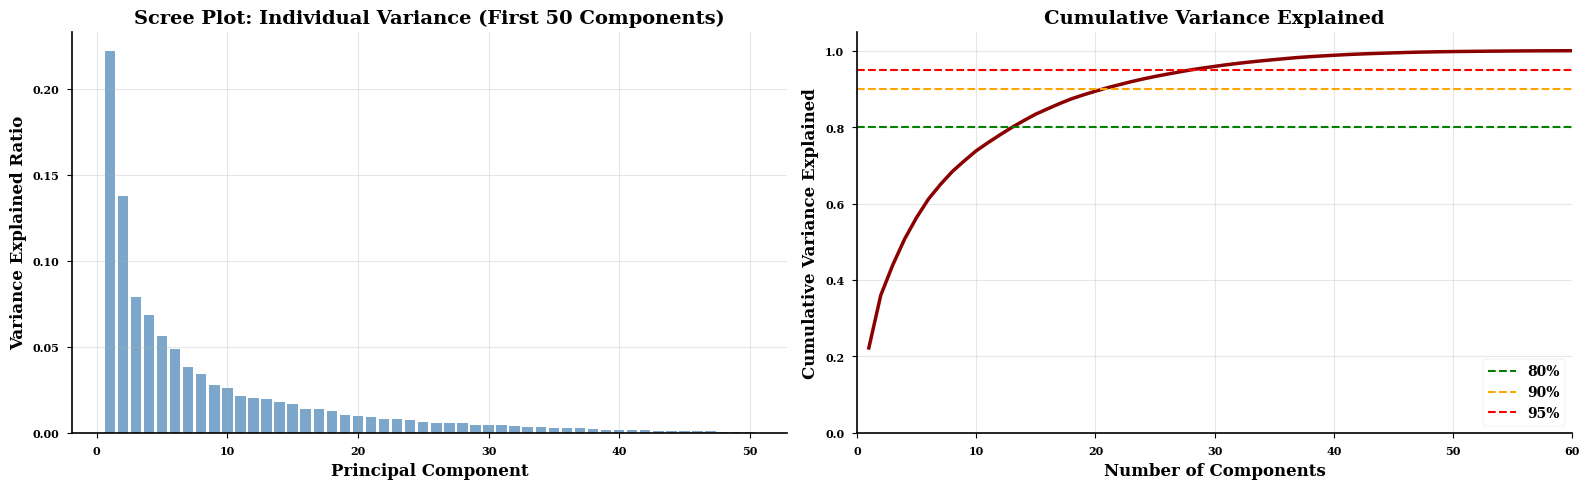


✓ Saved to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/pca/variance_explained.png


In [12]:
# Scree plot and cumulative variance
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Individual variance (first 50 components)
n_plot = min(50, len(pca.explained_variance_ratio_))
axes[0].bar(
    range(1, n_plot + 1),
    pca.explained_variance_ratio_[:n_plot],
    alpha=0.7,
    color="steelblue",
)
axes[0].set_xlabel("Principal Component", fontsize=12)
axes[0].set_ylabel("Variance Explained Ratio", fontsize=12)
axes[0].set_title(
    f"Scree Plot: Individual Variance (First {n_plot} Components)",
    fontsize=14,
    fontweight="bold",
)
axes[0].grid(True, alpha=0.3)

# Cumulative variance
axes[1].plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    linewidth=2.5,
    color="darkred",
)
axes[1].axhline(y=0.80, color="green", linestyle="--", linewidth=1.5, label="80%")
axes[1].axhline(y=0.90, color="orange", linestyle="--", linewidth=1.5, label="90%")
axes[1].axhline(y=0.95, color="red", linestyle="--", linewidth=1.5, label="95%")
axes[1].set_xlabel("Number of Components", fontsize=12)
axes[1].set_ylabel("Cumulative Variance Explained", fontsize=12)
axes[1].set_title("Cumulative Variance Explained", fontsize=14, fontweight="bold")
axes[1].legend(loc="lower right", fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, min(60, len(cumulative_variance)))
axes[1].set_ylim(0, 1.05)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "pca/variance_explained.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n✓ Saved to {FIGURES_DIR / 'pca/variance_explained.png'}")

In [13]:
# Show first 20 components
variance_df = pd.DataFrame(
    {
        "Component": range(1, 21),
        "Variance": pca.explained_variance_ratio_[:20],
        "Cumulative": cumulative_variance[:20],
    }
)

print("\nFirst 20 Principal Components:")
print(variance_df.to_string(index=False))


First 20 Principal Components:
 Component  Variance  Cumulative
         1  0.222153    0.222153
         2  0.137749    0.359902
         3  0.078790    0.438691
         4  0.068402    0.507093
         5  0.056120    0.563214
         6  0.048452    0.611666
         7  0.038036    0.649702
         8  0.034030    0.683732
         9  0.027849    0.711581
        10  0.026337    0.737918
        11  0.021494    0.759412
        12  0.020406    0.779818
        13  0.019462    0.799281
        14  0.017792    0.817072
        15  0.016931    0.834004
        16  0.013976    0.847979
        17  0.013653    0.861632
        18  0.012447    0.874080
        19  0.010361    0.884441
        20  0.009497    0.893938


## 9. Select Optimal Number of Components


In [14]:
# Choose target variance (typically 85-90% for microstructure features)
target_variance = 0.90
n_components_selected = np.argmax(cumulative_variance >= target_variance) + 1

print(f"Selected components: {n_components_selected}")
print(f"Variance explained: {cumulative_variance[n_components_selected-1]:.4f}")
print(f"Dimensionality reduction: {X_train.shape[1]} → {n_components_selected}")
print(f"Compression ratio: {n_components_selected / X_train.shape[1]:.2%}")

Selected components: 21
Variance explained: 0.9030
Dimensionality reduction: 81 → 21
Compression ratio: 25.93%


In [15]:
# Refit with selected components
pca_final = PCA(n_components=n_components_selected, random_state=42)
X_train_pca = pca_final.fit_transform(X_train_scaled)
X_test_pca = pca_final.transform(X_test_scaled)

print(f"Train PCA shape: {X_train_pca.shape}")
print(f"Test PCA shape: {X_test_pca.shape}")

Train PCA shape: (460, 21)
Test PCA shape: (115, 21)


## 10. Principal Component Interpretation

Understand what each component represents by examining feature loadings.


In [16]:
# Get component loadings
loadings = pca_final.components_.T  # Shape: (n_features, n_components)

loadings_df = pd.DataFrame(
    loadings,
    columns=[f"PC{i+1}" for i in range(n_components_selected)],
    index=microstructure_features,
)

print(f"Loadings shape: {loadings_df.shape}")
print("\nFirst 10 features, first 5 PCs:")
print(loadings_df.iloc[:10, :5].to_string())

Loadings shape: (81, 21)

First 10 features, first 5 PCs:
                           PC1       PC2       PC3       PC4       PC5
agg_volume            0.107445  0.143955  0.144473 -0.072720 -0.058417
agg_vwap             -0.123236  0.208049 -0.125264  0.110197 -0.082520
agg_open             -0.124113  0.207444 -0.122486  0.118715 -0.072646
agg_close            -0.122545  0.208712 -0.126451  0.103754 -0.086752
agg_high             -0.116242  0.213744 -0.123548  0.113417 -0.083229
agg_low              -0.129950  0.203422 -0.125306  0.105373 -0.078764
agg_trades            0.132523  0.085585  0.082202  0.013098 -0.092797
agg_estimated_spread  0.191626  0.078345  0.048363  0.072688 -0.035913
agg_mid_price        -0.123260  0.208708 -0.124538  0.109448 -0.081043
agg_relative_spread   0.192266  0.076638  0.048837  0.071450 -0.034687


In [17]:
# Identify top features for each PC
def get_top_features(loadings_df, pc_name, n_top=10):
    """Get top N features with highest absolute loadings."""
    abs_loadings = loadings_df[pc_name].abs().sort_values(ascending=False)
    top_features = abs_loadings.head(n_top)

    # Get actual loading values (with sign)
    top_with_sign = loadings_df.loc[top_features.index, pc_name]

    return pd.DataFrame(
        {
            "Feature": top_features.index,
            "Loading": top_with_sign.values,
            "Abs_Loading": top_features.values,
        }
    )


# Analyze first 5 PCs
for i in range(min(5, n_components_selected)):
    pc_name = f"PC{i+1}"
    print(f"\n{'='*80}")
    print(f"{pc_name} - Variance: {pca_final.explained_variance_ratio_[i]:.4f}")
    print(f"{'='*80}")
    top = get_top_features(loadings_df, pc_name, n_top=10)
    print(top.to_string(index=False))


PC1 - Variance: 0.2222
              Feature  Loading  Abs_Loading
agg_realized_vol_5min 0.209816     0.209816
 agg_spread_5min_mean 0.209210     0.209210
    adv_vol_ewma_slow 0.199245     0.199245
   adv_rv_scale_15min 0.195659     0.195659
   adv_rv_scale_10min 0.194751     0.194751
  agg_relative_spread 0.192266     0.192266
    agg_parkinson_vol 0.192266     0.192266
      agg_price_range 0.192244     0.192244
           agg_gk_vol 0.191865     0.191865
 agg_estimated_spread 0.191626     0.191626

PC2 - Variance: 0.1377
              Feature  Loading  Abs_Loading
     trade_arrival_cv 0.220846     0.220846
    trade_trade_count 0.214362     0.214362
trade_trade_intensity 0.214362     0.214362
             agg_high 0.213744     0.213744
    agg_typical_price 0.208761     0.208761
            agg_close 0.208712     0.208712
        agg_mid_price 0.208708     0.208708
             agg_vwap 0.208049     0.208049
             agg_open 0.207444     0.207444
              agg_low 0.2034

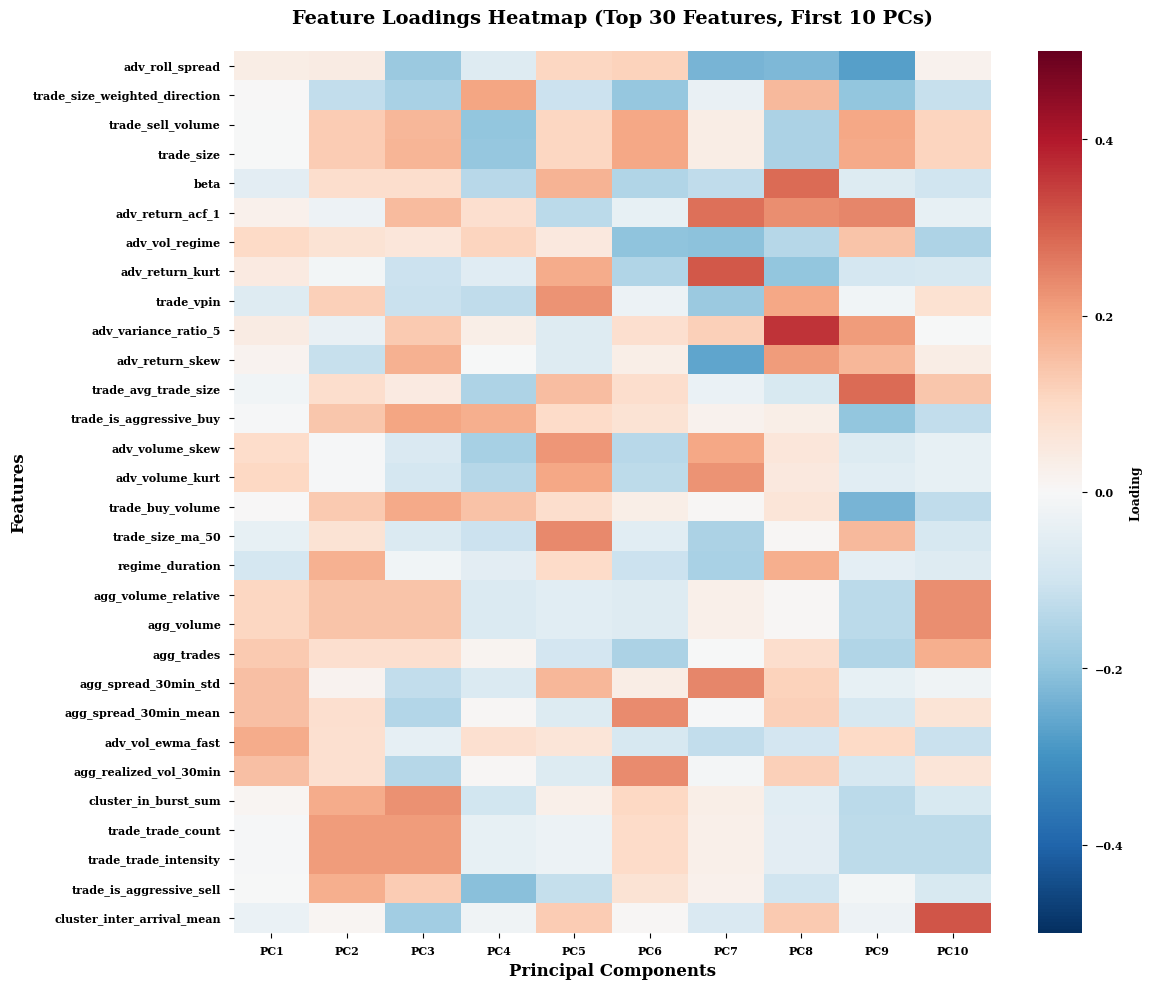


✓ Saved to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/pca/loadings_heatmap.png


In [18]:
# Visualize loadings heatmap
n_pcs_plot = min(10, n_components_selected)
n_features_plot = 30

# Select top features with highest variance across first 10 PCs
feature_variance = (
    loadings_df.iloc[:, :n_pcs_plot].abs().sum(axis=1).sort_values(ascending=False)
)
top_features_idx = feature_variance.head(n_features_plot).index

plt.figure(figsize=(12, 10))
sns.heatmap(
    loadings_df.loc[top_features_idx, [f"PC{i+1}" for i in range(n_pcs_plot)]],
    cmap="RdBu_r",
    center=0,
    cbar_kws={"label": "Loading"},
    yticklabels=True,
    vmin=-0.5,
    vmax=0.5,
)
plt.title(
    f"Feature Loadings Heatmap (Top {n_features_plot} Features, First {n_pcs_plot} PCs)",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
plt.xlabel("Principal Components", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "pca/loadings_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n✓ Saved to {FIGURES_DIR / 'pca/loadings_heatmap.png'}")

## 11. Visualize Principal Components


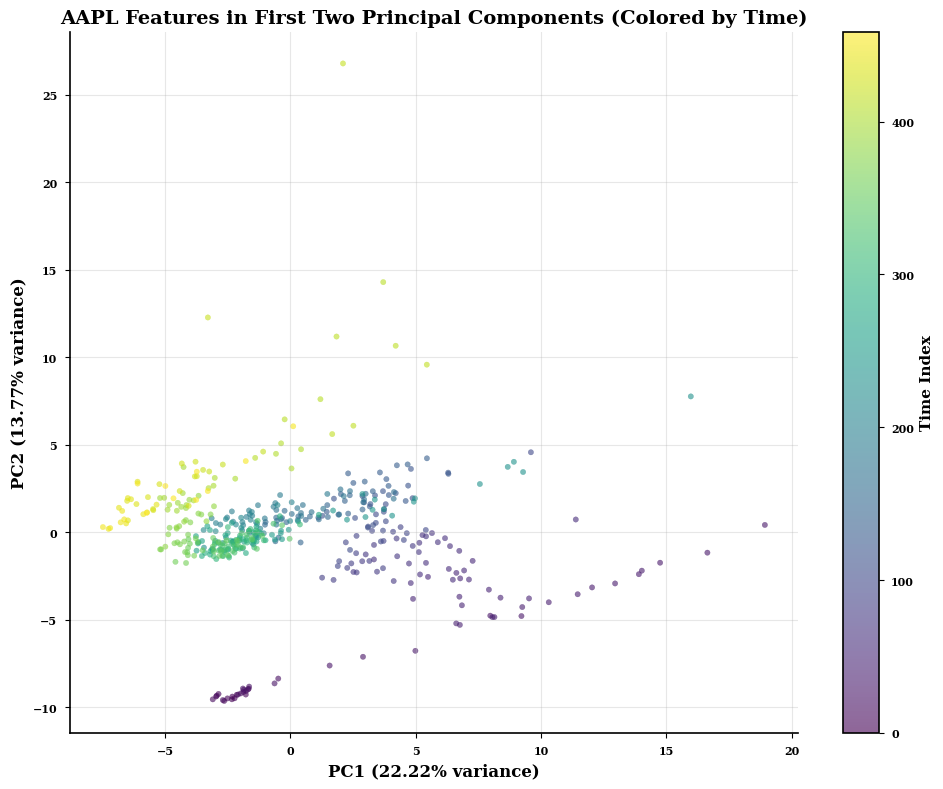


✓ Saved to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/pca/2d_projection.png


In [19]:
# 2D scatter: first two PCs
fig, ax = plt.subplots(figsize=(10, 8))

# Sample for plotting
sample_rate = max(1, len(X_train_pca) // 3000)
sample_idx = np.arange(0, len(X_train_pca), sample_rate)

scatter = ax.scatter(
    X_train_pca[sample_idx, 0],
    X_train_pca[sample_idx, 1],
    c=sample_idx,
    cmap="viridis",
    alpha=0.6,
    s=15,
)

ax.set_xlabel(
    f"PC1 ({pca_final.explained_variance_ratio_[0]:.2%} variance)", fontsize=12
)
ax.set_ylabel(
    f"PC2 ({pca_final.explained_variance_ratio_[1]:.2%} variance)", fontsize=12
)
ax.set_title(
    "AAPL Features in First Two Principal Components (Colored by Time)",
    fontsize=14,
    fontweight="bold",
)
ax.grid(True, alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Time Index", fontsize=11)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "pca/2d_projection.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n✓ Saved to {FIGURES_DIR / 'pca/2d_projection.png'}")

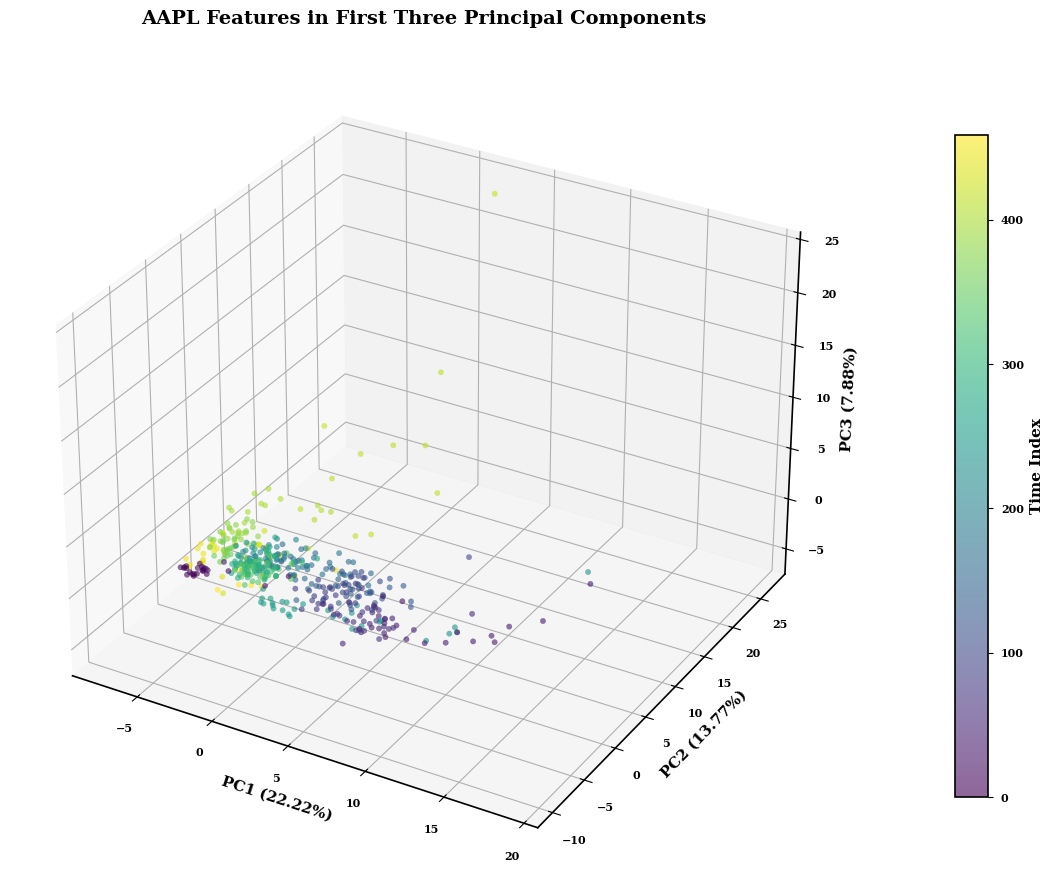


✓ Saved to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/pca/3d_projection.png


In [20]:
# 3D scatter: first three PCs
if n_components_selected >= 3:
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection="3d")

    scatter = ax.scatter(
        X_train_pca[sample_idx, 0],
        X_train_pca[sample_idx, 1],
        X_train_pca[sample_idx, 2],
        c=sample_idx,
        cmap="viridis",
        alpha=0.6,
        s=15,
    )

    ax.set_xlabel(f"PC1 ({pca_final.explained_variance_ratio_[0]:.2%})", fontsize=11)
    ax.set_ylabel(f"PC2 ({pca_final.explained_variance_ratio_[1]:.2%})", fontsize=11)
    ax.set_zlabel(f"PC3 ({pca_final.explained_variance_ratio_[2]:.2%})", fontsize=11)
    ax.set_title(
        "AAPL Features in First Three Principal Components",
        fontsize=14,
        fontweight="bold",
        pad=20,
    )

    cbar = plt.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)
    cbar.set_label("Time Index", fontsize=11)

    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "pca/3d_projection.png", dpi=300, bbox_inches="tight")
    plt.show()

    print(f"\n✓ Saved to {FIGURES_DIR / 'pca/3d_projection.png'}")

## 12. PCA Stability Analysis

Test if PCA structure is stable across different time windows.


In [21]:
# Split into time windows
n_windows = 5
window_size = len(X_train_scaled) // n_windows

print(f"Analyzing PCA stability across {n_windows} time windows")
print(f"Window size: ~{window_size:,} samples\n")

window_results = []

for i in range(n_windows):
    start_idx = i * window_size
    end_idx = (i + 1) * window_size if i < n_windows - 1 else len(X_train_scaled)

    X_window = X_train_scaled[start_idx:end_idx]

    # Fit PCA
    pca_window = PCA(n_components=n_components_selected, random_state=42)
    pca_window.fit(X_window)

    window_results.append(
        {
            "window": i + 1,
            "pca": pca_window,
            "variance": pca_window.explained_variance_ratio_,
            "start": start_idx,
            "end": end_idx,
        }
    )

    print(
        f"Window {i+1}: samples {start_idx:,}-{end_idx:,}, "
        f"variance: {pca_window.explained_variance_ratio_.sum():.4f}"
    )

Analyzing PCA stability across 5 time windows
Window size: ~92 samples

Window 1: samples 0-92, variance: 0.9839
Window 2: samples 92-184, variance: 0.9789
Window 3: samples 184-276, variance: 0.9826
Window 4: samples 276-368, variance: 0.9789
Window 5: samples 368-460, variance: 0.9768


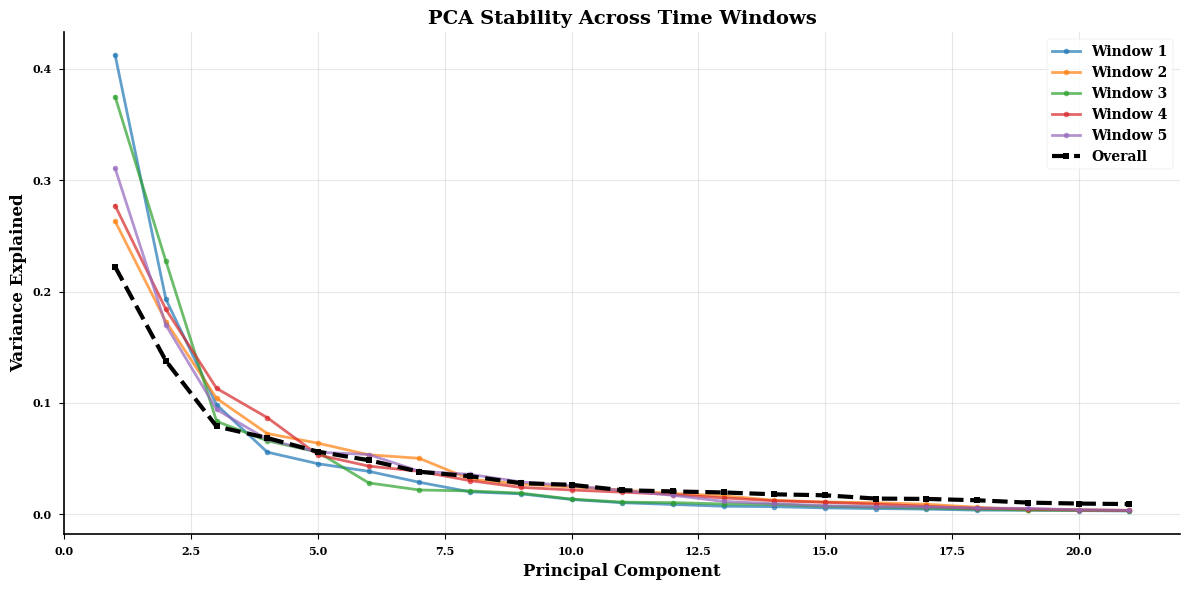


✓ Saved to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/pca/stability_variance.png


In [22]:
# Compare variance across windows
fig, ax = plt.subplots(figsize=(12, 6))

for result in window_results:
    ax.plot(
        range(1, n_components_selected + 1),
        result["variance"],
        marker="o",
        label=f"Window {result['window']}",
        alpha=0.7,
        linewidth=2,
        markersize=4,
    )

# Overall PCA
ax.plot(
    range(1, n_components_selected + 1),
    pca_final.explained_variance_ratio_,
    marker="s",
    label="Overall",
    linewidth=3,
    color="black",
    linestyle="--",
    markersize=5,
)

ax.set_xlabel("Principal Component", fontsize=12)
ax.set_ylabel("Variance Explained", fontsize=12)
ax.set_title("PCA Stability Across Time Windows", fontsize=14, fontweight="bold")
ax.legend(loc="best", fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "pca/stability_variance.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n✓ Saved to {FIGURES_DIR / 'pca/stability_variance.png'}")

In [23]:
# Calculate loading similarity
def loading_similarity(pca1, pca2, n_components=5):
    """Average absolute correlation between corresponding PCs."""
    correlations = []
    for i in range(min(n_components, pca1.n_components_, pca2.n_components_)):
        corr = np.corrcoef(pca1.components_[i], pca2.components_[i])[0, 1]
        correlations.append(abs(corr))
    return np.mean(correlations)


print("\nLoading Similarity (correlation with overall PCA):")
print("Higher = more stable\n")

similarities = []
for result in window_results:
    sim = loading_similarity(result["pca"], pca_final, n_components=5)
    similarities.append(sim)
    print(f"Window {result['window']}: {sim:.4f}")

avg_sim = np.mean(similarities)
std_sim = np.std(similarities)

print(f"\nAverage similarity: {avg_sim:.4f}")
print(f"Std deviation: {std_sim:.4f}")

if avg_sim > 0.80:
    print("\n✓ PCA structure is STABLE")
elif avg_sim > 0.60:
    print("\n⚠ PCA structure has MODERATE stability - consider periodic recalibration")
else:
    print("\n✗ PCA structure is UNSTABLE - frequent recalibration needed")


Loading Similarity (correlation with overall PCA):
Higher = more stable

Window 1: 0.4235
Window 2: 0.2784
Window 3: 0.2114
Window 4: 0.1644
Window 5: 0.2240

Average similarity: 0.2603
Std deviation: 0.0893

✗ PCA structure is UNSTABLE - frequent recalibration needed


## 13. Save PCA-Transformed Features


In [24]:
# Create DataFrames
pca_columns = [f"PC{i+1}" for i in range(n_components_selected)]

# Train set
train_pca_df = pd.DataFrame(X_train_pca, columns=pca_columns, index=X_train.index)
train_pca_df["timestamp"] = features_merged.iloc[:split_idx]["timestamp"].values

# Test set
test_pca_df = pd.DataFrame(X_test_pca, columns=pca_columns, index=X_test.index)
test_pca_df["timestamp"] = features_merged.iloc[split_idx:]["timestamp"].values

# Add time features back
time_cols_available = [
    col
    for col in exclude_features
    if col in features_merged.columns and col != "timestamp"
]
for col in time_cols_available:
    train_pca_df[col] = features_merged.iloc[:split_idx][col].values
    test_pca_df[col] = features_merged.iloc[split_idx:][col].values

print(f"Train PCA shape: {train_pca_df.shape}")
print(f"Test PCA shape: {test_pca_df.shape}")
print(f"\nColumns: {list(train_pca_df.columns[:10])} ...")

Train PCA shape: (460, 25)
Test PCA shape: (115, 25)

Columns: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'] ...


In [25]:
# Save DataFrames
train_pca_df.to_parquet(PROCESSED_DATA_DIR / "AAPL_features_pca_train.parquet")
test_pca_df.to_parquet(PROCESSED_DATA_DIR / "AAPL_features_pca_test.parquet")

print("✓ Saved PCA-transformed features:")
print(f"  {PROCESSED_DATA_DIR / 'AAPL_features_pca_train.parquet'}")
print(f"  {PROCESSED_DATA_DIR / 'AAPL_features_pca_test.parquet'}")

✓ Saved PCA-transformed features:
  /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../data/processed/AAPL_features_pca_train.parquet
  /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../data/processed/AAPL_features_pca_test.parquet


In [26]:
# Save PCA model and scaler
import joblib

joblib.dump(pca_final, MODELS_DIR / "pca_model.pkl")
joblib.dump(scaler, MODELS_DIR / "scaler.pkl")

print("✓ Saved models:")
print(f"  {MODELS_DIR / 'pca_model.pkl'}")
print(f"  {MODELS_DIR / 'scaler.pkl'}")

✓ Saved models:
  /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../models/pca_model.pkl
  /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../models/scaler.pkl


In [27]:
# Save metadata
import json

metadata = {
    "n_original_features": int(len(microstructure_features)),
    "n_components": int(n_components_selected),
    "variance_explained": float(cumulative_variance[n_components_selected - 1]),
    "compression_ratio": float(n_components_selected / len(microstructure_features)),
    "target_variance": float(target_variance),
    "microstructure_features": microstructure_features,
    "time_features": time_cols_available,
    "stability_avg": float(avg_sim),
    "stability_std": float(std_sim),
}

with open(MODELS_DIR / "pca_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

print("✓ Saved metadata:")
print(f"  {MODELS_DIR / 'pca_metadata.json'}")
print(f"\nMetadata summary:")
print(f"  Original features: {metadata['n_original_features']}")
print(f"  Selected components: {metadata['n_components']}")
print(f"  Variance explained: {metadata['variance_explained']:.4f}")
print(f"  Compression ratio: {metadata['compression_ratio']:.2%}")

✓ Saved metadata:
  /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../models/pca_metadata.json

Metadata summary:
  Original features: 81
  Selected components: 21
  Variance explained: 0.9030
  Compression ratio: 25.93%


## 14. Summary


In [28]:
print("=" * 80)
print("PCA DIMENSIONALITY REDUCTION SUMMARY - AAPL")
print("=" * 80)

print(f"\nOriginal Features:      {len(microstructure_features)}")
print(f"Selected Components:    {n_components_selected}")
print(f"Variance Explained:     {cumulative_variance[n_components_selected-1]:.2%}")
print(
    f"Compression Ratio:      {n_components_selected / len(microstructure_features):.2%}"
)
print(
    f"Dimensionality:         {len(microstructure_features)} → {n_components_selected}"
)

print("\n" + "=" * 80)
print("TOP 3 PRINCIPAL COMPONENTS")
print("=" * 80)
for i in range(min(3, n_components_selected)):
    pc_name = f"PC{i+1}"
    top = get_top_features(loadings_df, pc_name, n_top=5)
    print(f"\n{pc_name} ({pca_final.explained_variance_ratio_[i]:.2%} variance):")
    for idx, row in top.iterrows():
        print(f"  {row['Feature']:40s} {row['Loading']:7.4f}")

print("\n" + "=" * 80)
print("STABILITY ANALYSIS")
print("=" * 80)
print(f"Average Loading Similarity: {avg_sim:.4f}")
print(f"Stability: ", end="")
if avg_sim > 0.80:
    print("STABLE")
elif avg_sim > 0.60:
    print("MODERATE - periodic recalibration recommended")
else:
    print("UNSTABLE - frequent recalibration needed")

print("\n" + "=" * 80)
print("OUTPUT FILES")
print("=" * 80)
print("Data:")
print(f"  {PROCESSED_DATA_DIR / 'AAPL_features_pca_train.parquet'}")
print(f"  {PROCESSED_DATA_DIR / 'AAPL_features_pca_test.parquet'}")
print("\nModels:")
print(f"  {MODELS_DIR / 'pca_model.pkl'}")
print(f"  {MODELS_DIR / 'scaler.pkl'}")
print(f"  {MODELS_DIR / 'pca_metadata.json'}")
print("\nFigures:")
for fig_name in [
    "variance_explained.png",
    "loadings_heatmap.png",
    "2d_projection.png",
    "3d_projection.png",
    "stability_variance.png",
]:
    fig_path = FIGURES_DIR / "pca" / fig_name
    if fig_path.exists():
        print(f"  {fig_name}")

print("\n" + "=" * 80)
print("NEXT STEPS")
print("=" * 80)
print("1. Notebook 30: HMM regime detection using PCA features")
print("2. Notebooks 40-50: Predictive models (RF, XGBoost) with PCA features")
print("3. Compare performance: original features vs PCA features")
print("4. Monitor PCA stability in production")
print("=" * 80)

PCA DIMENSIONALITY REDUCTION SUMMARY - AAPL

Original Features:      81
Selected Components:    21
Variance Explained:     90.30%
Compression Ratio:      25.93%
Dimensionality:         81 → 21

TOP 3 PRINCIPAL COMPONENTS

PC1 (22.22% variance):
  agg_realized_vol_5min                     0.2098
  agg_spread_5min_mean                      0.2092
  adv_vol_ewma_slow                         0.1992
  adv_rv_scale_15min                        0.1957
  adv_rv_scale_10min                        0.1948

PC2 (13.77% variance):
  trade_arrival_cv                          0.2208
  trade_trade_count                         0.2144
  trade_trade_intensity                     0.2144
  agg_high                                  0.2137
  agg_typical_price                         0.2088

PC3 (7.88% variance):
  cluster_in_burst_sum                      0.2278
  trade_trade_count                         0.2111
  trade_trade_intensity                     0.2111
  trade_is_aggressive_buy                   0